# Stock Return Direction Prediction
# Problem: Cross-sectional Classification
# Models: Baseline + Logistic + Random Forest + Neural Network

## Data Collection and Preparation

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import wrds
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Getting data from wrds
db = wrds.Connection()

# Get both CRSP and Compustat data in one query
crsp = db.raw_sql("""
    SELECT 
        a.permno, a.date, a.ret, a.prc, a.vol, a.shrout,
        c.niq, c.ceqq, c.atq, c.prccq, c.cshoq, c.datadate
    FROM crsp.msf a
    LEFT JOIN crsp.ccmxpf_linktable b 
        ON a.permno = b.lpermno
        AND b.linktype IN ('LU', 'LC')
        AND b.linkprim IN ('P', 'C')
        AND a.date >= b.linkdt 
        AND (a.date <= b.linkenddt OR b.linkenddt IS NULL)
    LEFT JOIN comp.fundq c 
        ON b.gvkey = c.gvkey
        AND c.datadate <= a.date
        AND c.datadate >= a.date - INTERVAL '6 months'
        AND c.ceqq > 0 
        AND c.niq IS NOT NULL
    WHERE a.date >= '2018-01-01' AND a.date <= '2024-12-01'
        AND a.prc IS NOT NULL AND a.ret IS NOT NULL
    LIMIT 50000
""")
print(f"   Loaded: {len(crsp):,} records")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
   Loaded: 50,000 records


In [3]:
# Deduplication to avoid inflating ROE and PB's feature importance
crsp = crsp.sort_values(['permno', 'date', 'datadate'], ascending=[True, True, False])
crsp = crsp.drop_duplicates(subset=['permno', 'date'], keep='first')
print(f"   After deduplication: {len(crsp):,} records")
final_check = crsp.groupby(['permno', 'date']).size()
if (final_check > 1).any():
    print("   ERROR: Still have duplicates!")
else:
    print("   Deduplication successful: Each stock-month is unique")

   After deduplication: 22,795 records
   Deduplication successful: Each stock-month is unique


In [6]:
# Calculate ROE and PB from the merged data
crsp['roe'] = crsp['niq'] / crsp['ceqq']
crsp['pb'] = (crsp['prccq'] * crsp['cshoq']) / crsp['ceqq']
print(f"   Records with ROE/PB: {crsp['roe'].notna().sum():,}")

   Records with ROE/PB: 22,795


In [7]:
# Create Modeling Copy and Basic Variable Cleanup
df = crsp.copy()
df.rename(columns={'permno': 'stock_id',
                   'prc': 'price',
                   'vol': 'volume'}, inplace=True)

# Firm size proxy
df['market_cap'] = df['price'].abs() * df['shrout']
df = df.sort_values(['stock_id', 'date']).reset_index(drop=True)


In [8]:
# Feature Engineering
# Market-based features
df['momentum'] = df.groupby('stock_id')['ret'].shift(1)
df['volatility'] = df.groupby('stock_id')['ret'].transform(
    lambda x: x.rolling(12, min_periods=3).std().shift(1))
df['ma'] = df.groupby('stock_id')['price'].transform(
    lambda x: x.rolling(20, min_periods=5).mean())
df['ma_gap'] = (df['price'] - df['ma']) / df['ma'].replace(0, 1)
df['vol_change'] = df.groupby('stock_id')['volume'].pct_change()

# Firm characteristics
df['log_mcap'] = np.log(df['market_cap'] + 1)
df['roe_norm'] = (df['roe'] - df.groupby('date')['roe'].transform('mean')) / df.groupby('date')['roe'].transform('std')

In [9]:
# Target Variable and Feature Set
df['next_ret'] = df.groupby('stock_id')['ret'].shift(-1)
features = ['momentum','volatility','ma_gap','vol_change','log_mcap','roe_norm','pb']

In [10]:
# Remove invalid observations
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=features + ['next_ret']).copy()
# Create binary return-direction label
df['label'] = (df['next_ret'] > 0).astype(int)

## EDA Figures

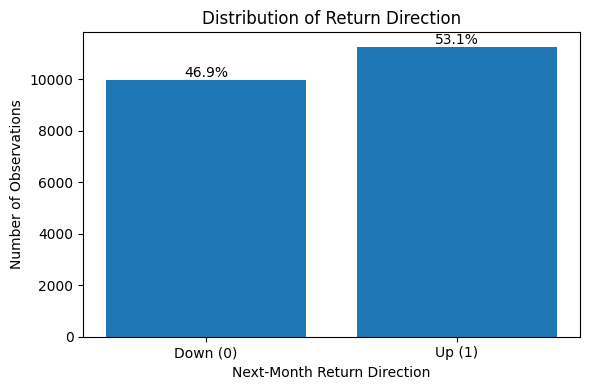

In [11]:
# EDA Figure E1: Return Direction Distribution
plt.figure(figsize=(6, 4))
counts = df['label'].value_counts().sort_index()
plt.bar(['Down (0)', 'Up (1)'], counts.values)
plt.title("Distribution of Return Direction")
plt.ylabel("Number of Observations")
plt.xlabel("Next-Month Return Direction")
# Annotate percentages
total = counts.sum()
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v/total:.1%}", ha='center', va='bottom')
plt.tight_layout()
plt.savefig("figure_E1_return_direction.png", dpi=300)
plt.show()

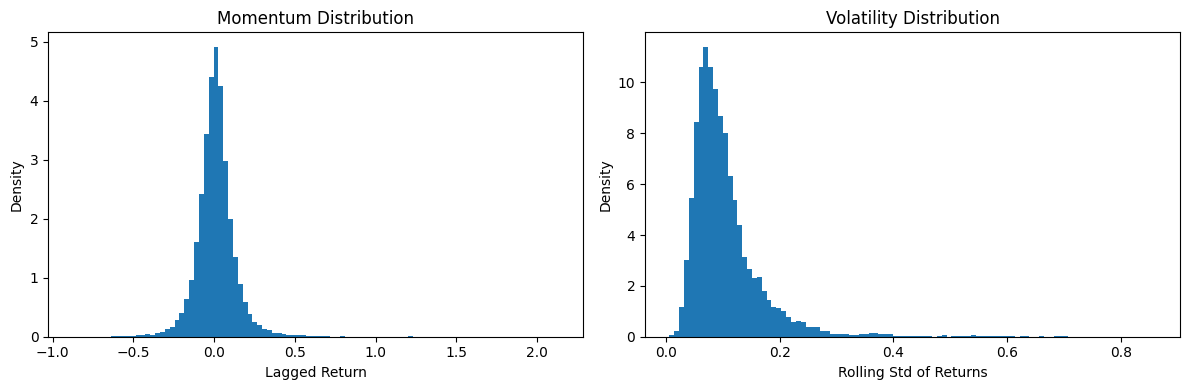

In [12]:
# EDA Figure E2: Feature Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Momentum distribution
axes[0].hist(df['momentum'], bins=100, density=True)
axes[0].set_title("Momentum Distribution")
axes[0].set_xlabel("Lagged Return")
axes[0].set_ylabel("Density")
# Volatility distribution
axes[1].hist(df['volatility'], bins=100, density=True)
axes[1].set_title("Volatility Distribution")
axes[1].set_xlabel("Rolling Std of Returns")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.savefig("figure_E2_feature_distributions.png", dpi=300)
plt.show()

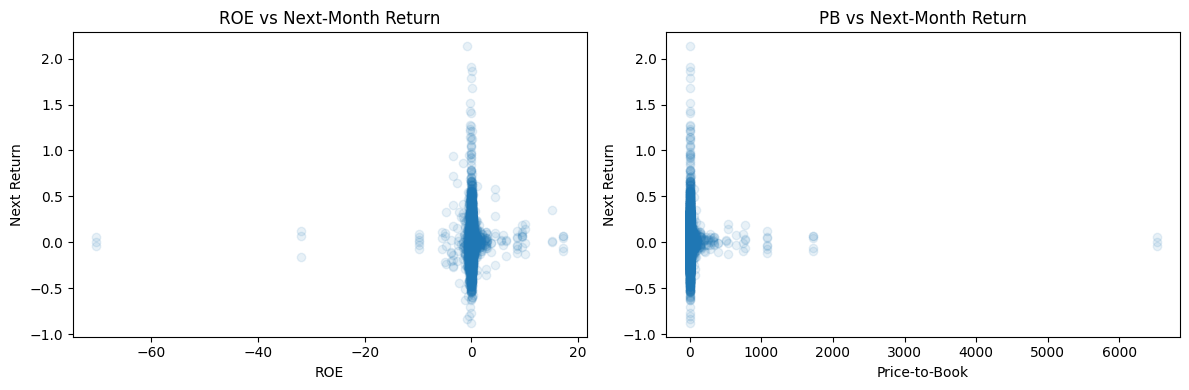

In [13]:
# EDA Figure E3: Fundamentals vs Next Return
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(df['roe'], df['next_ret'], alpha=0.1)
axes[0].set_title("ROE vs Next-Month Return")
axes[0].set_xlabel("ROE")
axes[0].set_ylabel("Next Return")
axes[1].scatter(df['pb'], df['next_ret'], alpha=0.1)
axes[1].set_title("PB vs Next-Month Return")
axes[1].set_xlabel("Price-to-Book")
axes[1].set_ylabel("Next Return")
plt.tight_layout()
plt.savefig("figure_E3_fundamentals_NextReturn.png", dpi=300)
plt.show()

## Data Preparation for Modeling

In [14]:
# Save full processed dataset
df.to_csv('stock_data_prepared.csv', index=False)
print(f"   Saved: stock_data_prepared.csv ({len(df):,} rows)")

   Saved: stock_data_prepared.csv (21,224 rows)


In [15]:
# Targetting and Splitting Data
X = df[features].values
y = df['label'].values
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
# Scaling Variables
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Model Building and Training

In [17]:
# Baseline, avoid error from unbalanced data
baseline_acc = max(np.mean(y_train), 1 - np.mean(y_train))
print(f"   Baseline (Majority Class): {baseline_acc:.4f}")

   Baseline (Majority Class): 0.5314


In [18]:
# Logistic Regression
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train_sc, y_train)
y_pred_lg = logit.predict(X_test_sc)
y_prob_lg = logit.predict_proba(X_test_sc)
acc_lg = accuracy_score(y_test, y_pred_lg)
print(f"   Logistic Reg.:  {acc_lg:.4f}")

   Logistic Reg.:  0.5453


In [19]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10,
                            random_state=42, n_jobs=-1)
rf.fit(X_train_sc, y_train)
y_pred_rf = rf.predict(X_test_sc)
y_prob_rf = rf.predict_proba(X_test_sc)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"   Random Forest:  {acc_rf:.4f}")

   Random Forest:  0.5564


In [20]:
# Neural Network
# Define a feedforward neural network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [21]:
# Initialize neural network model
net = Net()
# Loss function: cross-entropy for binary classification
criterion = nn.CrossEntropyLoss()
# Optimizer: stochastic gradient descent with momentum
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [22]:
# Convert NumPy arrays to PyTorch tensors
X_train_t = torch.FloatTensor(X_train_sc)
y_train_t = torch.LongTensor(y_train)
X_test_t = torch.FloatTensor(X_test_sc)

In [23]:
# Train the network for a fixed number of epochs
for _ in range(100):
    optimizer.zero_grad()                    
    loss = criterion(net(X_train_t), y_train_t)  
    loss.backward()                           
    optimizer.step()                          
# Disable gradient tracking for evaluation
with torch.no_grad():
    out = net(X_test_t)                      
    y_pred_nn = torch.argmax(out, dim=1).numpy()  
    acc_nn = accuracy_score(y_test, y_pred_nn)
print(f"   Neural Network: {acc_nn:.4f}")

   Neural Network: 0.5371


## Model Interpretation

In [24]:
# Feature importance ranking
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

In [25]:
# Feature ranking by logistic regression coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': logit.coef_[0]
}).sort_values('coefficient', ascending=False)

## Model Result Figures

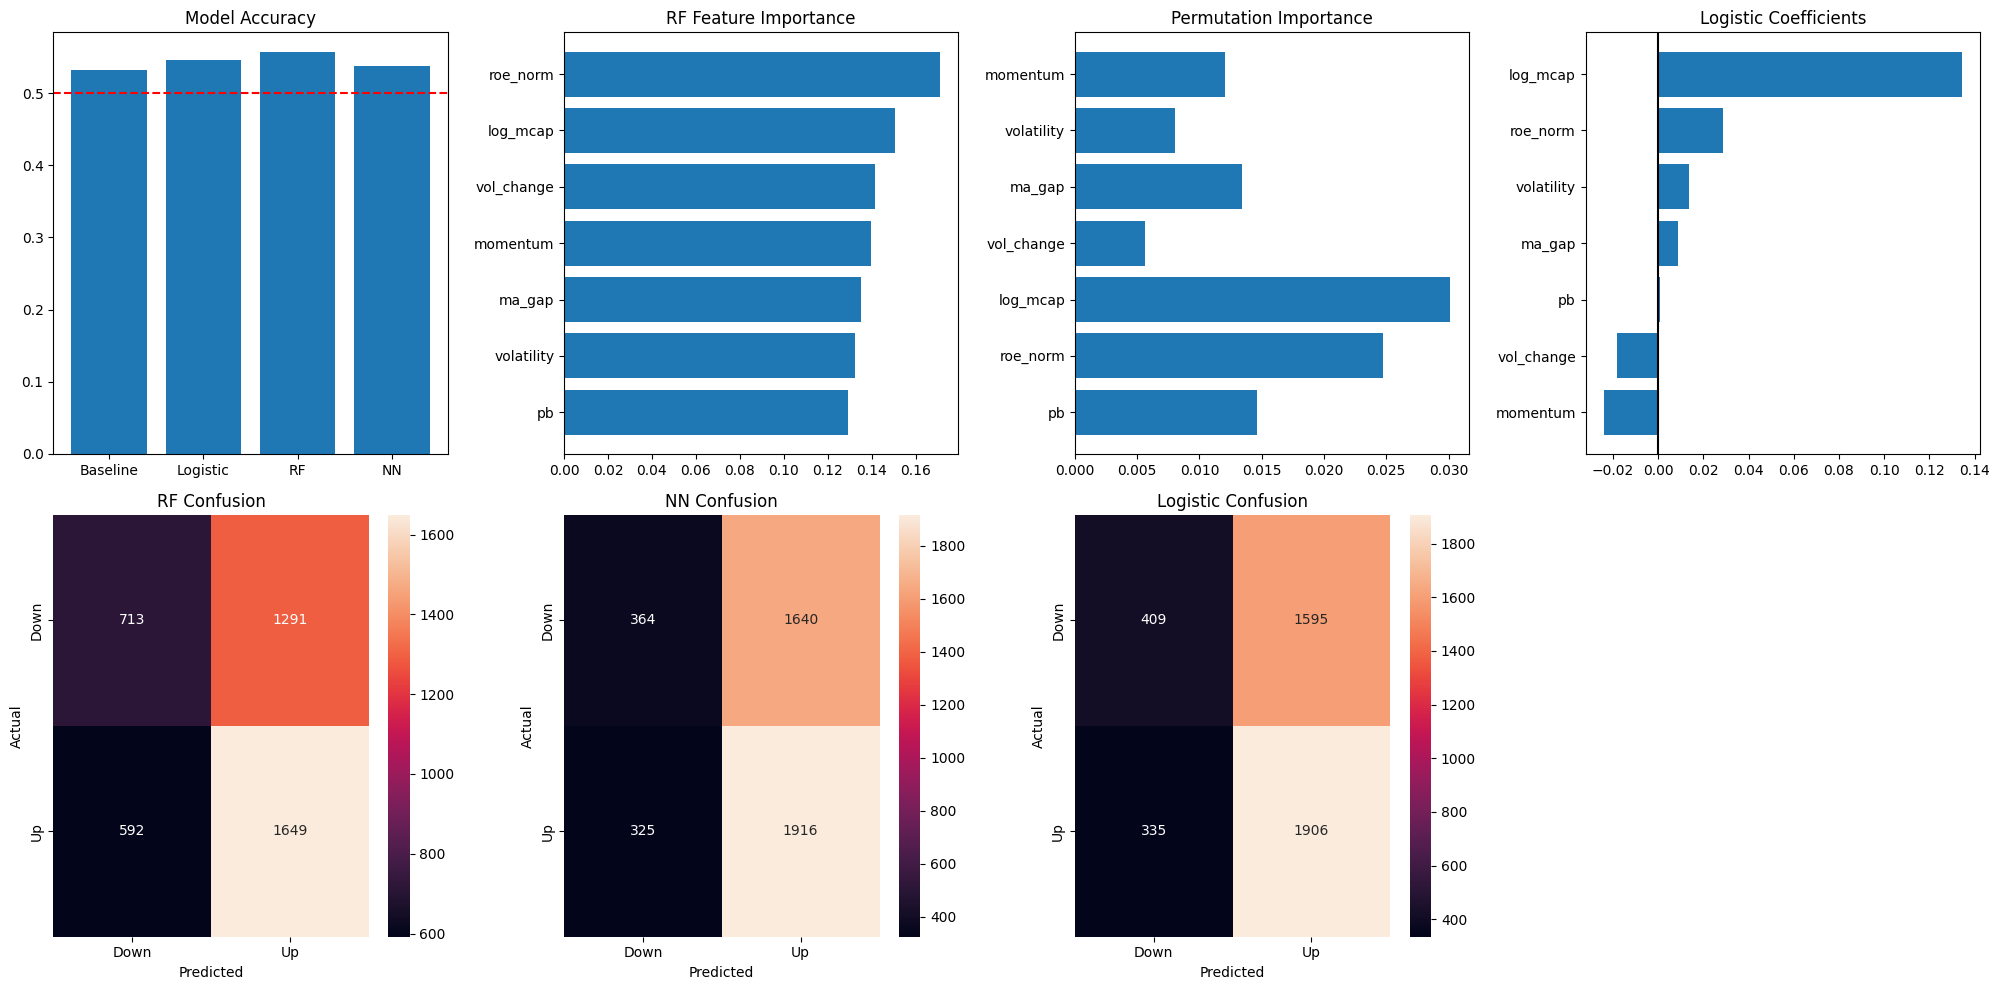

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Accuracy comparison
axes[0, 0].bar(
    ['Baseline', 'Logistic', 'RF', 'NN'],
    [baseline_acc, acc_lg, acc_rf, acc_nn]
)
axes[0, 0].axhline(0.5, color='red', linestyle='--')
axes[0, 0].set_title("Model Accuracy")
# RF importance
axes[0, 1].barh(feat_imp['feature'], feat_imp['importance'])
axes[0, 1].set_title("RF Feature Importance")
axes[0, 1].invert_yaxis()
# Permutation importance
perm_imp = []
base = accuracy_score(y_test, y_pred_rf)
for i in range(len(features)):
    Xp = X_test_sc.copy()
    np.random.shuffle(Xp[:, i])
    perm_imp.append(base - accuracy_score(y_test, rf.predict(Xp)))
axes[0, 2].barh(features, perm_imp)
axes[0, 2].set_title("Permutation Importance")
axes[0, 2].invert_yaxis()
# Logistic coefficients
axes[0, 3].barh(coef_df['feature'], coef_df['coefficient'])
axes[0, 3].axvline(0, color='black')
axes[0, 3].set_title("Logistic Coefficients")
axes[0, 3].invert_yaxis()
# Confusion matrices
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', ax=axes[1, 0],
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
axes[1, 0].set_title("RF Confusion")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_nn),
            annot=True, fmt='d', ax=axes[1, 1],
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
axes[1, 1].set_title("NN Confusion")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_lg),
            annot=True, fmt='d', ax=axes[1, 2],
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
axes[1, 2].set_title("Logistic Confusion")
axes[1, 2].set_xlabel("Predicted")
axes[1, 2].set_ylabel("Actual")
axes[1, 3].axis('off')

plt.tight_layout()
plt.savefig("stock_prediction_results.png", dpi=300)
plt.show()